# Dimensionality Reduction via PCA

In this post we will play around with Dimensionality Reduction via Principal Component Analysis (PCA).
All the details about the math and the logic behind this topic are available in the blog post I published a couple of days ago, [Bridging Recommender Systems and Dimensionality Reduction](http://francescopochetti.com/bridging-recommender-systems-dimensionality-reduction/). As I have extensively treated the topic already, I will not get into the technical details again.
We are going to learn how PCA works applying it to three separate examples

1. Given a 2D toy dataset, we will reduce its dimensionality projecting the points onto a 1D straight line. This is purely didactic and will give us the intuition of what is happening under the hood. In 2D it is very easy to spot trends and to display the axes of maximum variance the algorithm spits out.
2. Once figured out the intuition, we will apply PCA to a real life dataset, a cropped version of the [labeled faces in the wild](http://vis-www.cs.umass.edu/lfw/). The idea here is that we have $32 \times 32$ pixels greyscale pictures of faces and we want to reduce their size to $10 \times 10$, keeping as much information as possible about the original image. We still want to be able to recognize whose face we are looking at. It turns out that this is prefectly possible running PCA on the picture and projecting it on the subspace mapped by its top 100 (we can choose as many as we wish) principal components. This is an outstanding result as we will be able to shrink the size to less than half the original, still being able to "read" the face.
3. Last but not least we are going to follow up on the $K$-Means Clustering example I treated [here](http://francescopochetti.com/k-means-clustering/). The idea was to apply clustering to image compression. In a 24-bit color representation of an image, 1 each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often refered to as the RGB encoding. Our image contained thousands of colors, still we managed to reduce their number to only to 16. We treated every pixel in the original image as a data example and used the K-means algorithm to find the 16 colors that best grouped (clustered) the pixels in the 3-dimensional RGB space. Once computed the cluster centroids on the image, we used the 16 colors to replace the pixels in the original image. Here we are going a step further, trying to visualize the clustering results in the 3D RGB space and then reducing the dimensionality to 2D via PCA.

### Functions

In [2]:
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis= 0)
    X = (X-mu)/sigma
    return X, mu, sigma

def pca(X):
    m = X.shape[0]
    sigma = (1/m)*np.dot(X.T, X)
    u, s, vh = np.linalg.svd(sigma, full_matrices=True, compute_uv=True)
    return u, s

def drawLine(p1, p2):
    plt.plot(p1, p2, color='black', linestyle='dashed')

def projectData(X, U, K):
    U_reduced = U[:, 0:K]
    return np.dot(X, U_reduced), U_reduced

def recoverData(Z, U, K):
    return np.dot(Z, U.T)

def displayData(X):
    m = int(np.sqrt(X.shape[1]))
    fig = plt.figure(figsize=(8,8))
    plt.title('100 Random faces from the data set')
    random.seed(0)
    indexes = random.sample(range(1, X.shape[0]), 100)
    images = X[indexes,:]
    for i in np.arange(10):
        for j in np.arange(10):
            ax = fig.add_subplot(10, 10, (10*j+i)+1)
            ax.matshow(ndimage.rotate(images[10*j+i,:].reshape(m,m),-90), cmap = 'gray')
            plt.yticks(())
            plt.xticks(())
            plt.axis('tight')
    plt.show()
    
def findClosestCentroids(X, centroids):
    '''
    FINDCLOSESTCENTROIDS computes the centroid memberships for every example
       idx = FINDCLOSESTCENTROIDS (X, centroids) returns the closest centroids
       in idx for a dataset X where each row is a single example. idx = m x 1 
       vector of centroid assignments (i.e. each entry in range [1..K])

    '''
    idx = np.zeros((X.shape[0], 1))
    for p in range(X.shape[0]):
        idx[p] = np.argmin(np.linalg.norm(X[p, :] - centroids, axis=1))
    return idx + 1

def computeCentroids(X, idx, K):
    '''
    COMPUTECENTROIDS returns the new centroids by computing the means of the 
    data points assigned to each centroid.
       centroids = COMPUTECENTROIDS(X, idx, K) returns the new centroids by 
       computing the means of the data points assigned to each centroid. It is
       given a dataset X where each row is a single data point, a vector
       idx of centroid assignments (i.e. each entry in range [1..K]) for each
       example, and K, the number of centroids. You should return a matrix
       centroids, where each row of centroids is the mean of the data points
       assigned to it.

    '''  
    
    centroids = np.zeros((K, X.shape[1]))
    for i in range(K):
        centroids[i, :] = np.mean(X[(idx == (i+1)).nonzero()[0], :], axis=0)
    return centroids

def plotDataPoints(X, idx, K):
    colors = cm.rainbow(np.linspace(0, 1, 100))
    for k in range(K):
        plt.scatter(X[(idx == (k + 1)).nonzero()[0], 0], X[(idx == (k + 1 )).nonzero()[0], 1], s = 5, color=colors[random.randint(0, 99)])
         
def kMeansInitCentroids(X, K):
    '''
        KMEANSINITCENTROIDS This function initializes K centroids that are to be 
        used in K-Means on the dataset X
        centroids = KMEANSINITCENTROIDS(X, K) returns K initial centroids to be
        used with the K-Means on the dataset X
    '''
    
    X = np.random.permutation(X)
    return X[:K, :]
    
def drawLine(p1, p2):
    plt.plot(p1, p2, 'ro--')
    
def plotProgresskMeans(X, centroids, previous, idx, K, i):
    plotDataPoints(X, idx, K)
    #plt.scatter(centroids[:, 0], centroids[:, 1], linewidths=3, s = 5, c = 'red')   
        
def runkMeans(X, initial_centroids, max_iters, plot_progress):
    '''
    RUNKMEANS runs the K-Means algorithm on data matrix X, where each row of X
    is a single example
       [centroids, idx] = RUNKMEANS(X, initial_centroids, max_iters, ...
       plot_progress) runs the K-Means algorithm on data matrix X, where each 
       row of X is a single example. It uses initial_centroids used as the
       initial centroids. max_iters specifies the total number of interactions 
       of K-Means to execute. plot_progress is a true/false flag that 
       indicates if the function should also plot its progress as the 
       learning happens. This is set to false by default. runkMeans returns 
       centroids, a Kxn matrix of the computed centroids and idx, a m x 1 
       vector of centroid assignments (i.e. each entry in range [1..K])

    '''
    
    m = X.shape[0]
    n = X.shape[1]
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids
    idx = np.zeros((m, 1))
    for i in range(max_iters):
        idx = findClosestCentroids(X, centroids)
        previous_centroids = centroids        
        centroids = computeCentroids(X, idx, K)
        if plot_progress:
            plotProgresskMeans(X, centroids, previous_centroids, idx, K, i)
    plt.scatter(centroids[:, 0], centroids[:, 1], linewidths=3, s = 40, c = 'black', marker='x')
    return centroids, idx

## Part 1: From 2D to straight line. Visualizing the Principal Components

2D dataset. It seems like the 2 variables are strongly correlated.
We could think about condensing all the relevant information on one single line..

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random
from scipy import ndimage
from skimage import io

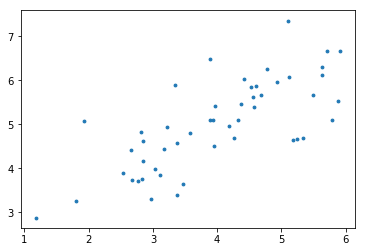

In [3]:
data = sio.loadmat('ex7data1.mat')
X = data['X']
plt.scatter(X[:, 0], X[:, 1], s=8)
plt.axis('tight')
plt.show()

### Normalize the data

Before using PCA, it is important to first **normalize the data** by substracting the mean value of each feature from the dataset, and scaling each dimension so that they are in the same range.

In [4]:
X_norm, average, sigma = featureNormalize(X)

After normalizing the data, we can run PCA to compute the principal components of the datasets. To do that, first we shoud compute the *covariance matrix* of the data, which is given by:
$$\sigma = \frac{1}{m} X^TX$$

where *X* is the data matrix with examples in rows, and *m* is the number of examples. <br>
After computing the covariance matrix, we can run the *Singular Value Decomposition* (SVD) algorithm. SVD will return two values: <br>  **U, S = np.linalg.svd(sigma, full_matrices=True)** <br>
where U will contain the principal components (namely, **direction vectors** $u^{(i)}$) and S will contain the diagonal matrix.

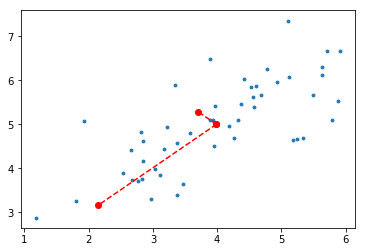

In [5]:
princip_varianU, princip_compS = pca(X_norm)
p1 = average + 1.5 * princip_compS[0] * princip_varianU[:, 0].T
p2 = average + 1.5 * princip_compS[1] * princip_varianU[:, 1].T
plt.scatter(X[:, 0], X[:, 1], s=8)
drawLine(np.array([average[0], p1[0]]), np.array([average[1], p1[1]]))
drawLine(np.array([average[0], p2[0]]), np.array([average[1], p2[1]]))

### Projecting the data onto a lower dimension K

After computin the principal components, we can use them to reduce the feature dimension of our dataset by projecting each example onto a lower dimensional space, $x^{(i)} \rightarrow z^{(i)} $ (e.g., projecting the data from 2D to 1D). <br>
To do that, we will use the eigenvectors (U matrix) returned by PCA and project the example dataset into a K-dimensional space. K in this example is 1, so we will select the first K (1) columns from our U matrix (we call this new matrix **Ureduce**) and then multiplying it to our normalized dataset.
$$Z = U_{reduce}^T X$$

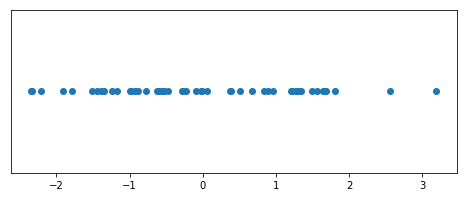

In [6]:
K=1
Z, U_Reduced = projectData(X_norm, princip_varianU, K)
plt.figure(figsize=(8, 3))
ones = np.ones((Z.shape[0], 1))
plt.scatter(Z, ones)
plt.yticks(())
plt.axis('tight')
plt.show()

### Reconstructing an approximation of the data

After projecting the data onto a lower dimensional space, we can approximately recover the data by projecting them back onto the original high dimensional space.

$$Z = U_{reduce}^T X \rightarrow X_{approx} = U_{reduce} Z^T \approx X$$

In [167]:
X_reconstructed = recoverData(Z, U_Reduced, K)

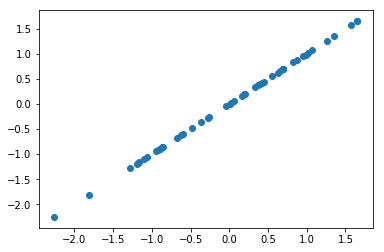

In [168]:
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1])
plt.show()

### Visualizing the projections

We can see in the plot how the projection and then reconstruction affects the data. In the plot, the original data point are indicated with the blue circels, while the projected data points are indicated with the red circles. The projection effectively only retains the information in the direction given by $U_{1}$.

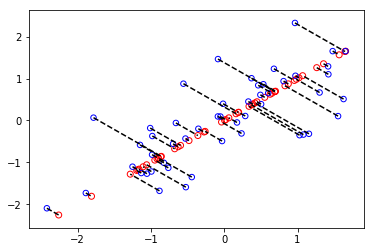

In [169]:
for i in range(X_norm.shape[0]):
    p1 = X_norm[i, :]
    p2 = X_reconstructed[i, :]
    drawLine(np.array([p1[0], p2[0]]), np.array([p1[1], p2[1]]))
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], color='red', facecolors='none')
plt.scatter(X_norm[:, 0], X_norm[:, 1], s=30, color='blue', facecolors='none')
plt.show()

## Part 2: PCA on the Face dataset

As you can see, the first set of images reproduce faces without any specific approximation. The second set, instead, show what happens when we shrink the size of the single pictures from $32 \times 32$ to $10 \times 10$ using PCA. The interesting aspect here is that even though we have more than halved the dimension, the faces are still pretty recognizable! This is because we have kept the most important information using PCA. 

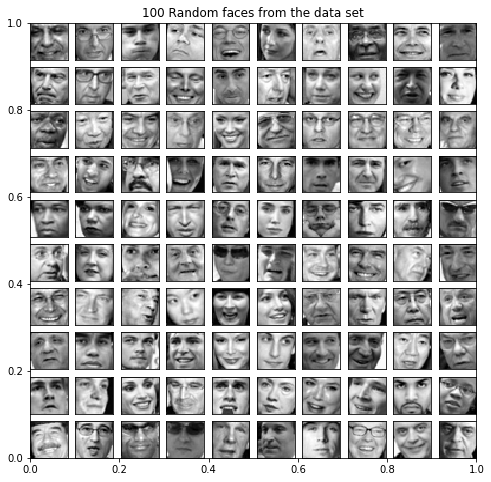

In [16]:
data = sio.loadmat('ex7faces.mat')
X = data['X']
displayData(X)

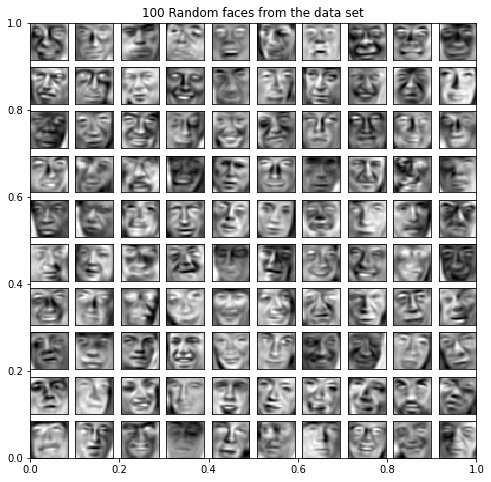

In [28]:
X_norm, average, sigma = featureNormalize(X)
princip_varianU, princip_compS = pca(X_norm)
K = 100
Z, U_Reduced = projectData(X_norm, princip_varianU, K)
X_reconstructed = recoverData(Z, U_Reduced, K)
displayData(X_reconstructed)

## Part 3: Visualizing K-Means Clusters via PCA

In [219]:
from skimage import io
import matplotlib.cm as cm

bird = io.imread('bird_small.png')

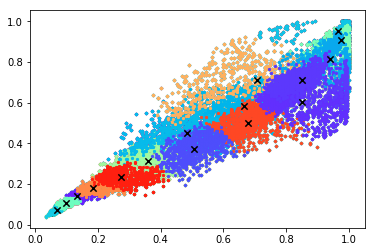

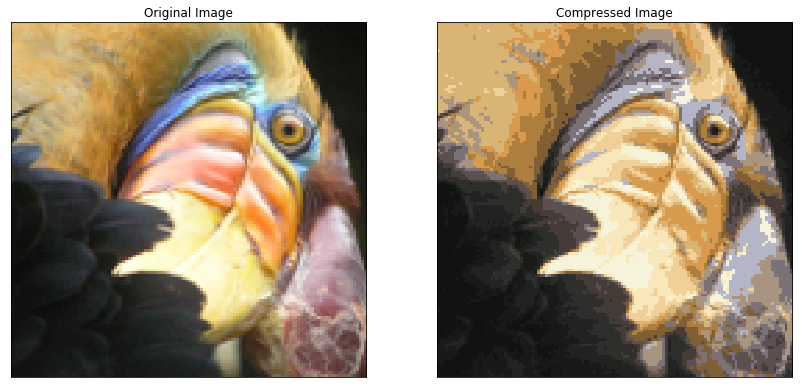

In [220]:
# Divide by 255 so that all values are in the range 0 - 1
bird = bird / 255
img_size = bird.shape

# Reshape the image into an Nx3 matrix where N = number of pixels.
# Each row will contain the Red, Green and Blue pixel values
# This gives us our dataset matrix X that we will use K-Means on
X = bird.reshape((img_size[0] * img_size[1], img_size[2]))
K = 16
max_iters = 12

# When using K-Means, it is important the initialize the centroids randomly
initial_centroids = kMeansInitCentroids(X, K)

# running K-means
centroids, idx = runkMeans(X, initial_centroids, max_iters, plot_progress=True)

bird_compressed = np.zeros((X.shape[0], X.shape[1]))

# We can now recover the image from the indices (idx) by mapping each pixel
# (specified by it's index in idx) to the centroid value
for i, cluster in enumerate(idx):
    bird_compressed[i,:] = centroids[int(cluster[0]) - 1,:]

# Reshape the recovered image into proper dimensions
bird_compressed = bird_compressed.reshape((img_size[0], img_size[1], img_size[2]))
fig = plt.figure(figsize=(14, 8))

ax1 = fig.add_subplot(121)
ax1.imshow(bird)
ax1.set_title('Original Image')
plt.xticks(())
plt.yticks(())

ax2 = fig.add_subplot(122)
ax2.imshow(bird_compressed)
ax2.set_title('Compressed Image')
plt.xticks(())
plt.yticks(())

plt.show()

Now that we have succesfully shrinked our bird, let's explore the results of the K-Means algorithm. How are pixels grouped together? We can visualize the data points in 3D and then projecting them on the best possible 2D axes provided by PCA

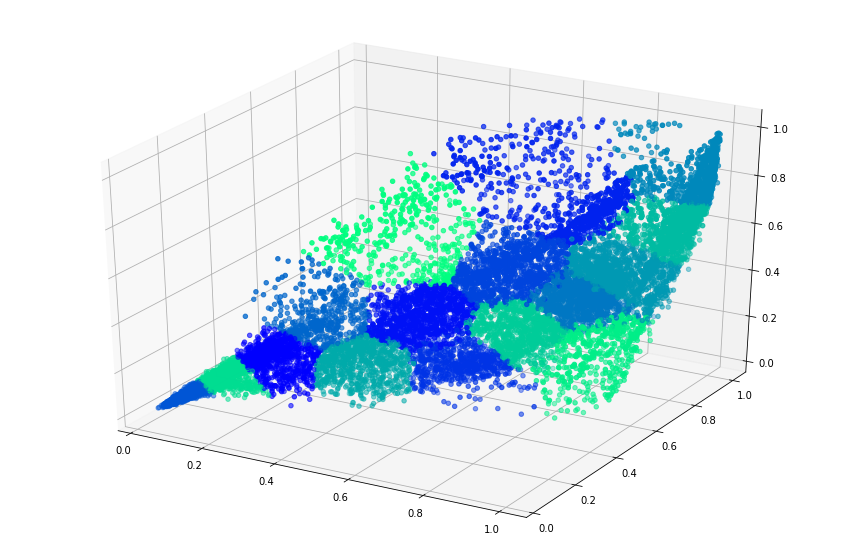

In [217]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
X = np.hstack((X, idx))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=X[:, 3], cmap='winter')
plt.show()

### Shrinking to 2D via Principal Component Analysis

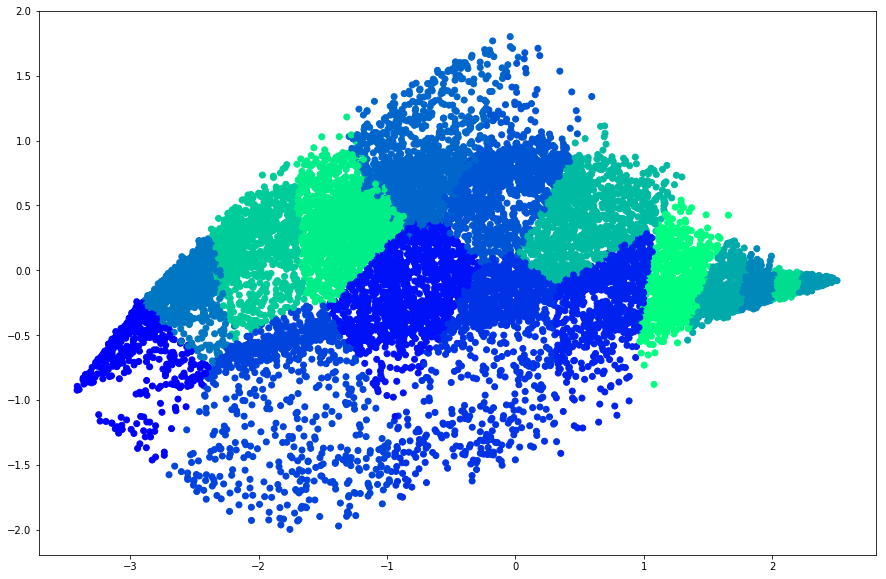

In [231]:
X_norm, average, sigma = featureNormalize(X)
princip_varianU, princip_compS = pca(X_norm)
K=2
Z, U_Reduced = projectData(X_norm, princip_varianU, K)

Z = np.hstack((Z, idx))
fig = plt.figure(figsize=(15,10))
plt.scatter(Z[:, 0], Z[:, 1], c=Z[:, 2], cmap='winter')
plt.show()

### Appendix: how to estimate if we have chosen a good K

To estimate if our choice of K is good, we need to take the principal components vector (S) returned from *svd* algorithm and verify that:

$$\frac{\sum_{i=1}^{k} S_i}{\sum_{i=1}^{m} S_i} \geq 0.99 $$

Take into account the example of second the part:

In [7]:
data = sio.loadmat('ex7faces.mat')
X = data['X']
X_norm, average, sigma = featureNormalize(X)
princip_varianU, princip_compS = pca(X_norm)
K = 100

Test with K=100:

In [8]:
princip_compS[:K].sum() / princip_compS[:].sum() 

0.9319320428645924

Here we can see that K=100 is not good enough, which means that we have lost to many informations during the dimensionality reduction. Try with K=350:

In [11]:
K = 350
princip_compS[:K].sum() / princip_compS[:].sum() 

0.9910059199951412

350 is a good value since it respects the disequation. Nice!